Домашнее задание
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [1]:
# !pip install scikit-uplift xgboost==1.0.2 category_encoders==2.1.0 -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
from sklift.metrics import qini_auc_score
from sklift.metrics import uplift_by_percentile
from sklift.metrics import weighted_average_uplift
from sklift.metrics import uplift_at_k
from sklift.models import TwoModels
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.viz import plot_uplift_by_percentile
from sklift.viz import plot_uplift_curve
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_preds

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
from sklearn.pipeline import Pipeline

In [6]:
# !pip install catboost

In [7]:
from catboost import CatBoostClassifier

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
from sklearn.utils.validation import check_consistent_length

In [10]:
# замена для родной функции из skuplift
def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

In [11]:
df = pd.read_csv('data.csv')

In [12]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [13]:
# переименовываем поля
df = df.rename(columns={'conversion':'target', 'offer':'treatment'})
df['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [14]:
#Производим замену полей на числовые признаки и преобразуем тип числовых признаков в int
df['treatment'].loc[df['treatment'] != 'No Offer'] = 1
df['treatment'].loc[df['treatment'] == 'No Offer'] = 0

C:\Python\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [15]:
df['treatment'] = df['treatment'].astype('int')
df['treatment'].unique()

array([1, 0])

In [16]:
# перед тем как разбить датасет на тренировочную и тестовую выборки сделаем feature engineering
y = df[['target']]
treatment = df[['treatment']]
X = df.drop(['treatment', 'target'], axis = 1)

In [17]:
y.head(3)

,target
0,0
1,0
2,0


In [18]:
treatment.head(3)

,treatment
0,1
1,0
2,1


In [19]:
X.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,142.44,1,0,Surburban,0,Phone
1,6,329.08,1,1,Rural,1,Web
2,7,180.65,0,1,Surburban,1,Web


In [20]:
# заменим is_referral и channel на цифровые признаки для более удобного послеующего взаимодействия.
X['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [21]:
X['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [22]:
X['channel'].loc[X['channel'] == 'Web'] = 2
X['channel'].loc[X['channel'] == 'Phone'] = 1
X['channel'].loc[X['channel'] == 'Multichannel'] = 0
X['channel'] = X['channel'].astype('int')

C:\Python\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [23]:
X['zip_code'].loc[X['zip_code'] == 'Surburban'] = 2
X['zip_code'].loc[X['zip_code'] == 'Urban'] = 1
X['zip_code'].loc[X['zip_code'] == 'Rural'] = 0
X['zip_code'] = X['zip_code'].astype('int')

In [24]:
X.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,142.44,1,0,2,0,1
1,6,329.08,1,1,0,1,2
2,7,180.65,0,1,2,1,2
3,9,675.83,1,0,0,1,2
4,2,45.34,1,0,1,0,2


In [25]:
# Создаем список с категориальными переменными
cat_features = ['recency', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']

In [26]:
# и разбиваем датасет на выбборки
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(X, 
                                                                                   y, 
                                                                                   treatment, 
                                                                                   test_size=0.1, 
                                                                                   random_state=35)

In [27]:
# словарь для записывания результатов
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': [],
}


In [28]:
models_results

{'approach': [], 'uplift@10%': [], 'uplift@20%': [], 'uplift@30%': []}

Проводим uplift-моделирование 3 способами: 
1. одна модель с признаком коммуникации (S learner), 
2. модель с трансформацией таргета (трансформация классов п. 2. 1)
3. вариант с двумя независимыми моделями

####  Одна модель с признаком коммуникации

In [29]:
# создаем класс
sm = SoloModel(
    CatBoostClassifier(
        iterations=20, 
        thread_count=2, 
        random_state=42, 
        silent=True))

In [30]:
%%time
# и обучаем
sm = sm.fit(
    X_train, 
    y_train, 
    treat_train, 
    estimator_fit_params={'cat_features': cat_features})

CPU times: total: 1.2 s
Wall time: 1.1 s


In [31]:
# предсказываем и считаем оценку для k=0.3
uplift_sm = sm.predict(X_test)
sm_score = uplift_at_k( y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

In [32]:
# записываем результаты в словарь
models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

In [33]:
# считаем оценку для k=0.2 (понимаю что костыли)
sm_score = uplift_at_k( y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
# записываем результаты в словарь 
models_results['uplift@20%'].append(sm_score)

In [34]:
# считаем оценку для k=0.1
sm_score = uplift_at_k( y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
# записываем результаты в словарь
models_results['uplift@10%'].append(sm_score)

In [35]:
models_results

{'approach': ['SoloModel'],
 'uplift@10%': [0.11267605633802819],
 'uplift@20%': [0.10417251457160312],
 'uplift@30%': [0.11386932707355242]}

In [36]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_

In [37]:
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

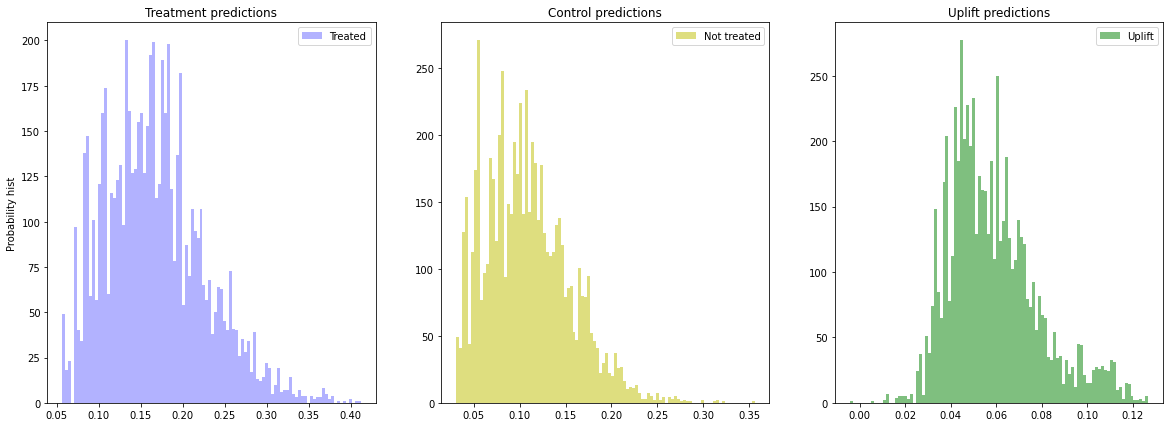

In [38]:
# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds_(sm_trmnt_preds , sm_ctrl_preds, bins=100);

C:\_GeekBrain\BigData2021\ML_in_business\venv\lib\site-packages\sklift\metrics\metrics.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  return auc_score_actual / auc_score_perfect


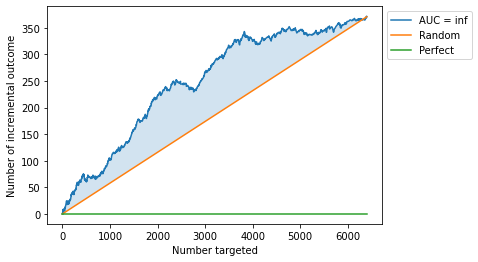

In [39]:
# Построим дополнительные графики для оценки uplift
# with ideal curve
# perfect=True
plot_uplift_curve(y_test, uplift_sm, treat_test); # perfect=True

In [40]:
# uplift by decile, или  uplift by percentile, или uplift by bin.
uplift_by_percentile(y_test, 
                     uplift_sm, 
                     treat_test, 
                     strategy='overall', 
                     total=True, 
                     std=True, 
                     bins=10)

C:\Python\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,440,200,0.281818,0.170000,0.111818,0.021447,0.026561,0.034139
10-20,438,202,0.203196,0.118812,0.084384,0.019226,0.022766,0.029798
20-30,417,223,0.225420,0.089686,0.135734,0.020463,0.019134,0.028015
30-40,422,218,0.165877,0.123853,0.042024,0.018107,0.022311,0.028734
40-50,438,202,0.157534,0.089109,0.068425,0.017407,0.020046,0.026549
50-60,406,234,0.162562,0.085470,0.077091,0.018311,0.018277,0.025872
60-70,422,218,0.116114,0.123853,-0.007739,0.015595,0.022311,0.027221
70-80,437,203,0.109840,0.098522,0.011318,0.014958,0.020917,0.025715
80-90,427,213,0.126464,0.103286,0.023177,0.016085,0.020853,0.026335


C:\Python\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


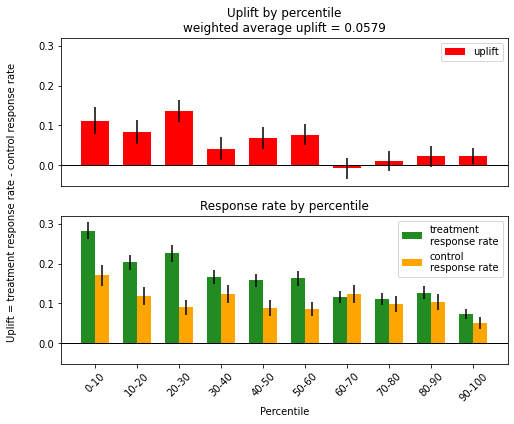

In [41]:
# график uplift by percentile
plot_uplift_by_percentile(y_test, 
                          uplift_sm, 
                          treat_test, 
                          strategy='overall', 
                          kind='bar');

In [42]:
# с помощью значений в столбцах uplift и n_treatment рассчитаем усредненный uplift на всей выборке, 
# взвешенный на размер целевой группы — weighted average uplift
uplift_full_data = weighted_average_uplift(y_test, 
                                           uplift_sm, 
                                           treat_test, 
                                           bins=10) 
print(f"weighted average uplift on full data: {uplift_full_data:.4f}")

weighted average uplift on full data: 0.0569


In [43]:
# выводим важности признаков из обученной модели
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,recency,21.878295
1,is_referral,21.705103
2,treatment,16.518701
3,used_bogo,8.953997
4,history,8.289842
5,zip_code,8.122473
6,channel,7.356624
7,used_discount,7.174965


#### Модель с модель с трансформацией таргета (используем тот же набор данных)

In [44]:
# создаем класс
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))

In [45]:
%%time
# и обучаем
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

CPU times: total: 1.12 s
Wall time: 827 ms


In [46]:
# предсказываем и считаем метрики качества
uplift_ct = ct.predict(X_test)
ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

In [47]:
# записываем результаты в словарь
models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

In [48]:
# считаем метрики качества для k=0.2 и записываем в словарь
ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
models_results['uplift@20%'].append(ct_score)

In [49]:
# считаем метрики качества для k=0.1 и записываем в словарь
ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
models_results['uplift@10%'].append(ct_score)

In [50]:
models_results

{'approach': ['SoloModel', 'ClassTransformation'],
 'uplift@10%': [0.11267605633802819, 0.08920187793427228],
 'uplift@20%': [0.10417251457160312, 0.09243267341446099],
 'uplift@30%': [0.11386932707355242, 0.09040248435054773]}

#### Две независимые модели
Объявляем две независимые модели

In [51]:
treat_train_np = np.array(treat_train['treatment'])

In [52]:
tm = TwoModels(  
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
) 

In [53]:
%time
# method ='ddr_control' ('ddr_treatment') - зависимые модели
# обучаем модели
tm = tm.fit(
    X_train, 
    y_train, 
    treat_train_np,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

CPU times: total: 0 ns
Wall time: 0 ns


In [54]:
# предсказываем и считаем метрики качества
uplift_tm = tm.predict(X_test)
tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

In [55]:
# записываем результаты в словарь
models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

In [56]:
# считаем метрики качества для k=0.2 и записываем в словарь
tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
models_results['uplift@20%'].append(tm_score)

In [57]:
# считаем метрики качества для k=0.1 и записываем в словарь
tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
models_results['uplift@10%'].append(tm_score)

In [58]:
models_results

{'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@10%': [0.11267605633802819, 0.08920187793427228, 0.09859154929577466],
 'uplift@20%': [0.10417251457160312, 0.09243267341446099, 0.09011277512672755],
 'uplift@30%': [0.11386932707355242, 0.09040248435054773, 0.0943503032081377]}

#### Строим графики

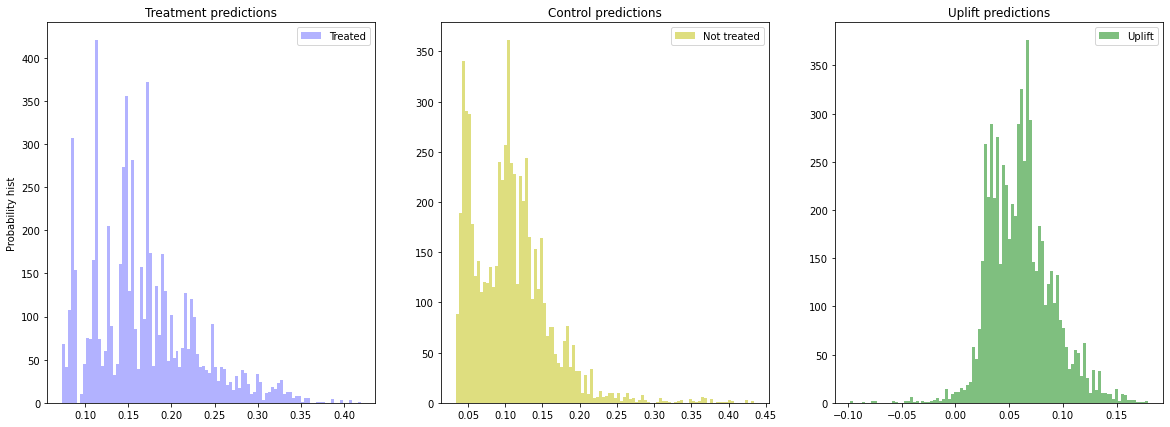

In [59]:
plot_uplift_preds_(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Solo Model


C:\_GeekBrain\BigData2021\ML_in_business\venv\lib\site-packages\sklift\metrics\metrics.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  return auc_score_actual / auc_score_perfect


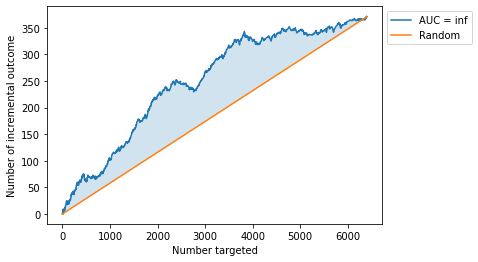

In [60]:
print('Solo Model')
plot_uplift_curve(y_test, uplift_sm, treat_test, perfect=False)
plt.show()

C:\_GeekBrain\BigData2021\ML_in_business\venv\lib\site-packages\sklift\metrics\metrics.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  return auc_score_actual / auc_score_perfect


ClassTransform Model


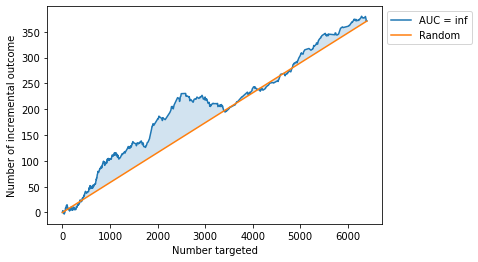

In [61]:
print('ClassTransform Model')
plot_uplift_curve(y_test, uplift_ct, treat_test, perfect=False)
plt.show()

Two Model


C:\_GeekBrain\BigData2021\ML_in_business\venv\lib\site-packages\sklift\metrics\metrics.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  return auc_score_actual / auc_score_perfect


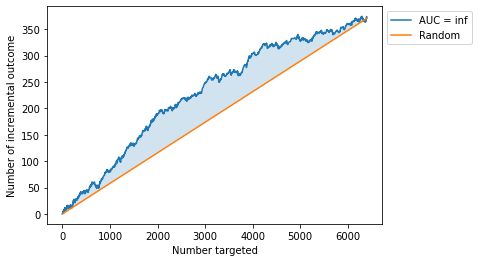

In [62]:
print('Two Model')
plot_uplift_curve(y_test, uplift_tm, treat_test, perfect=False)
plt.show()

In [63]:
uplift_by_percentile(y_test,uplift_tm, treat_test, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

C:\Python\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,434,206,0.258065,0.169903,0.088162,0.021004,0.026166,0.033553
10-20,440,200,0.186364,0.100000,0.086364,0.018564,0.021213,0.028189
20-30,419,221,0.186158,0.085973,0.100185,0.019015,0.018857,0.026780
30-40,423,217,0.163121,0.096774,0.066346,0.017965,0.020070,0.026936
40-50,446,194,0.163677,0.103093,0.060584,0.017519,0.021832,0.027992
50-60,430,210,0.132558,0.095238,0.037320,0.016353,0.020256,0.026033
60-70,414,226,0.154589,0.092920,0.061669,0.017767,0.019312,0.026242
70-80,413,227,0.135593,0.127753,0.007840,0.016846,0.022156,0.027833
80-90,422,218,0.111374,0.082569,0.028806,0.015314,0.018641,0.024125


C:\Python\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


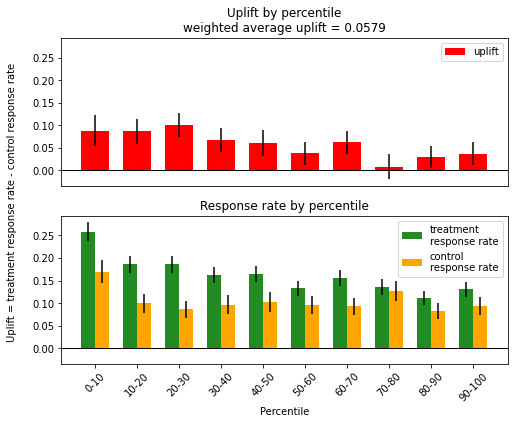

In [64]:
plot_uplift_by_percentile(y_test, uplift_tm, treat_test, 
                          strategy='overall', kind='bar'); # line

#### Выводим единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [65]:
models_results

{'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@10%': [0.11267605633802819, 0.08920187793427228, 0.09859154929577466],
 'uplift@20%': [0.10417251457160312, 0.09243267341446099, 0.09011277512672755],
 'uplift@30%': [0.11386932707355242, 0.09040248435054773, 0.0943503032081377]}

In [70]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@10%,uplift@20%,uplift@30%
0,SoloModel,0.112676,0.104173,0.113869
2,TwoModels,0.098592,0.090113,0.094350
1,ClassTransformation,0.089202,0.092433,0.090402


#### Cтроим модель UpliftTreeClassifier

In [67]:
# !pip install causalml

In [68]:
#!pip install causalml-0.10.0-cp38-cp38-win_amd64.whl

в итоге так и не смог установить Casualml